This study demonstrates how to classify a highly imbalanced dataset in which the number of examples in one class greatly outnumbers the examples in another.  This work contains complete code to:

* Load a CSV file using Pandas.
* Create train, validation, and test sets.
* Define and train a model using Keras (including setting class weights).
* Evaluate the model using various metrics (including precision and recall).
* Try common techniques for dealing with imbalanced data like:
    * Class weighting
    * Oversampling

In [2]:
import tensorflow as tf
from tensorflow import keras

import os, tempfile

import matplotlib as mpl, matplotlib.pyplot as plt
import numpy as np, pandas as pd, seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
#Data Processing
#Download the kaggle Credit Card Fraud data set

file = tf.keras.utils
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
raw_df[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V26', 'V27', 'V28', 'Amount', 'Class']].describe()

,Time,V1,V2,V3,V4,V5,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [7]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n  Total: {}\n  Positive: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

Examples:
  Total: 284807
  Positive: 492 (0.17% of total)



In [17]:
#Clean, split and Normalize data
#The `Amount` column covers a huge range. Convert to log-space to reduce its range.

cleaned_df = raw_df.copy()
cleaned_df.pop('Time')

eps = 0.001
cleaned_df['Log Amount'] = np.log(cleaned_df.pop('Amount') + eps)

######################################################################
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0

val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [18]:
#The StandardScaler is only fit using the train_features to be sure the model is not peeking at the validation or test sets.
scaler = StandardScaler()

train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)

print('Training lables shape:', train_labels.shape)
print('validation lables shape:', val_labels.shape)
print('Test lables shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training lables shape: (182276,)
validation lables shape: (45569,)
Test lables shape: (56962,)
Training features shape: (182276, 29)
validation features shape: (45569, 29)
Test features shape: (56962, 29)


In [19]:
#If you want to deploy a model, it's critical that you preserve the preprocessing calculations.
#The easiest way to implement them as layers, and attach them to your model before export.

/home/ubuntu/anaconda3/envs/technical-test/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ubuntu/anaconda3/envs/technical-test/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


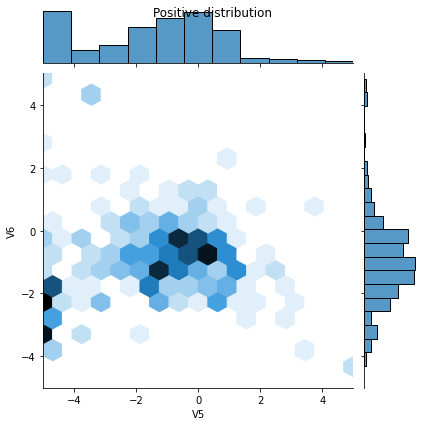

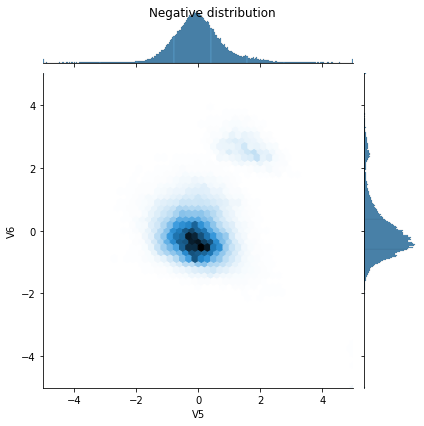

In [22]:
#Let's Look at the data distribution
pos_df = pd.DataFrame(train_features[bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(pos_df['V5'], pos_df['V6'], kind='hex', xlim=(-5,5), ylim=(-5, 5))
plt.suptitle("Positive distribution")

sns.jointplot(neg_df['V5'], neg_df['V6'], kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")

Next compare the distributions of the positive and negative examples over a few features. Good questions to ask at this point are:

* Do these distributions make sense?
    * Yes. You've normalized the input and these are mostly concentrated in the +/- 2 range.
* Can you see the difference between the distributions?
    * Yes the positive examples contain a much higher rate of extreme values.
    
Next Let's define the model and metrics:
    * Define a function that creates a simple neural network with a densly connected hidden layer, a dropout layer to reduce overfitting, and an output sigmoid layer that returns the probability of a transaction being fraudulent

In [24]:
METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
]

def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([keras.layers.Dense(16, activation='relu', input_shape=(train_features.shape[-1], )),
                                                keras.layers.Dropout(0.5),
                                                keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)])
    model.compile(optimizer=keras.optimizers.Adam(lr=1e-3), 
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=metrics)
    return model

#### Understanding useful metrics
Notice that there are a few metrics defined above that can be computed by the model that will be helpful when evaluating the performance.

 * **False negatives** and **false positives** are samples that were **incorrectly classified**
 * **True negatives** and **true positives** are samples that were **correctly classified**
 * **Accuracy** is the percentage of examples correctly classified > **True samples / total samples**
 * **Precision** is the percentage of predicted positives that were correctly classified > **True Positive / (True positive + False positive)**
 * **Recall** is the percentage of actual positives that were correctly classified > **True Positives / (True positives + False Negative)**
 * **AUC** refers to the Area Under the Curve of a Receiver Operating Characteristic curve (ROC-AUC). This metric is equal to the probability that a classifier will rank a random positive sample higher than a random negative sample.
 
Notice that the model is fit using a larger than default batch size of 2048, this is important to ensure that each batch has a decent chance of containing a few positive samples. If the batch size was too small, they would likely have no fraudulent transactions to learn from

In [25]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc',
                                                 verbose=1,
                                                 patience=10,
                                                 mode='max',
                                                 restore_best_weights=True)

In [26]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                480       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


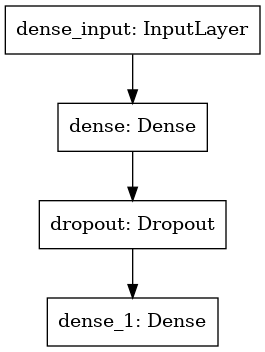

In [27]:
tf.keras.utils.plot_model(model)

In [33]:
#Let's test the untrained model
model.predict(train_features[:10])

array([[0.03602034],
       [0.01028278],
       [0.18860397],
       [0.10897079],
       [0.09464434],
       [0.10991278],
       [0.00590822],
       [0.10254371],
       [0.06027427],
       [0.09244975]], dtype=float32)

#### Set the correct initial bias
These initial guesses are not great. We know the dataset is imbalanced. Let's set the output layer's bias to reflect that [See: A Recipe for Training Neural Networks: "init well"](http://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines). This can help with initial convergence.

With the default bias initialization the loss should be about **math.log(2) = 0.69314 ?**

In [36]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print('Loss: {:0.4f}'.format(results[0])) #Initial Loss

Loss: 0.1052


The correct bias to set can be derived from:
$$ p_0 = pos/(pos + neg) = 1/(1+e^{-b_0}) $$ 

In [38]:
initial_bias = np.log([pos/neg])
initial_bias
#set that as the initial bias, and the model will give much more reasonable initial guesses. 
#Initial predictions should be close to pos/total = 0.00172

array([-6.35935934])

In [40]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

array([[0.00149223],
       [0.00936955],
       [0.00244066],
       [0.00149724],
       [0.00188413],
       [0.00266704],
       [0.6623065 ],
       [0.00344568],
       [0.00107625],
       [0.00290415]], dtype=float32)

With this initialization the **initial loss** should be approximately but certainly lower than the previous:
$$ -{p}_{0} log({p}_{0}) - (1 - {p}_{0}) log(1 - {p}_{0}) = 0.01317 $$

In [45]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print('Loss: {:0.4f}'.format(results[0]))

Loss: 0.0201


Let's Checkpoint the initial weights to make the various runs more comparable. Keep this initial weights in a checkpoint file and load them into each model before training.

In [46]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

**Let's confirm that the initial bias fix help by training 20 epochs with and without this careful initialization and compare the Losses**

In [47]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])

zero_bias_history = model.fit(train_features,
                             train_labels,
                             batch_size=BATCH_SIZE,
                             epochs=20,
                             validation_data=(val_features, val_labels),
                             verbose=0)

In [59]:
model = make_model()
model.load_weights(initial_weights)

careful_bias_history = model.fit(train_features,
                                train_labels,
                                batch_size=BATCH_SIZE,
                                epochs = 20,
                                validation_data=(val_features, val_labels),
                                verbose=0)

In [52]:
def plot_loss(history, label, n):
    plt.semilogy(history.epoch, history.history['loss'], color=colors[n], label='Train ' + label) 
    plt.semilogy(history.epoch, history.history['val_loss'], color=colors[n], label='Val ' + label, linestyle="--")

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

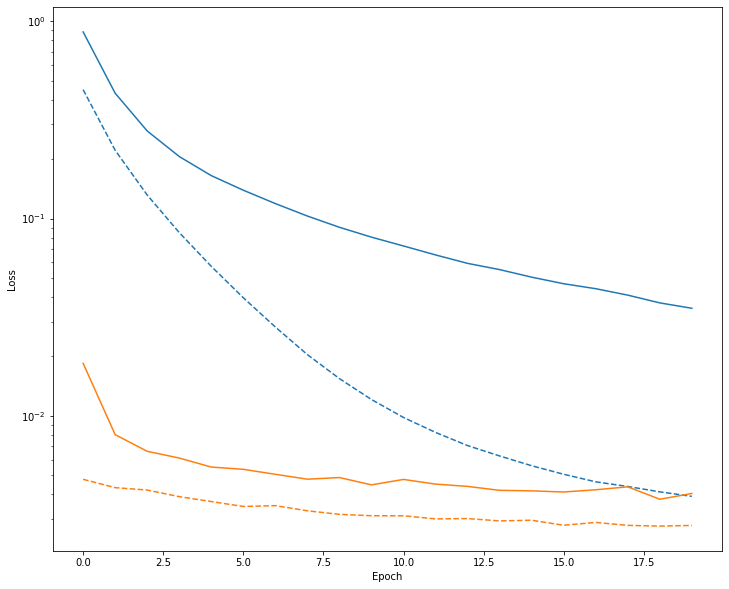

In [60]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

The above figure makes it clear: In terms of validation loss, on this problem, this careful initialization gives a clear advantage.

Now Let's Train the model

In [61]:
model = make_model()
model.load_weights(initial_weights)
base_line_history = model.fit(train_features,
                             train_labels,
                             batch_size=BATCH_SIZE,
                             epochs=EPOCHS,
                             callbacks=[early_stopping],
                             validation_data=(val_features, val_labels)
                             )

Epoch 1/100
90/90 [==============================] - 3s 19ms/step - loss: 0.0256 - tp: 114.6374 - fp: 299.3516 - tn: 139188.4176 - fn: 107.1648 - accuracy: 0.9972 - precision: 0.2916 - recall: 0.5427 - auc: 0.8840 - val_loss: 0.0048 - val_tp: 45.0000 - val_fp: 10.0000 - val_tn: 45493.0000 - val_fn: 21.0000 - val_accuracy: 0.9993 - val_precision: 0.8182 - val_recall: 0.6818 - val_auc: 0.9276
Epoch 2/100
90/90 [==============================] - 1s 8ms/step - loss: 0.0088 - tp: 84.7033 - fp: 50.6703 - tn: 93929.5165 - fn: 75.6813 - accuracy: 0.9986 - precision: 0.6139 - recall: 0.5473 - auc: 0.9031 - val_loss: 0.0043 - val_tp: 46.0000 - val_fp: 10.0000 - val_tn: 45493.0000 - val_fn: 20.0000 - val_accuracy: 0.9993 - val_precision: 0.8214 - val_recall: 0.6970 - val_auc: 0.9154
Epoch 3/100
90/90 [==============================] - 1s 8ms/step - loss: 0.0070 - tp: 88.2527 - fp: 22.5165 - tn: 93956.7143 - fn: 73.0879 - accuracy: 0.9989 - precision: 0.7697 - recall: 0.5185 - auc: 0.9132 - val_lo

Now let'scheck for **Overfitting** by producing plots of model's accuracy and loss on the training and validation set.

In [62]:
def plot_metrics(history):
    metrics = ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace('-', ' ').capitalize()
        plt.subplot(2, 2, n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8, 1])
        else:
            plt.ylim([0, 1])
        plt.legend()

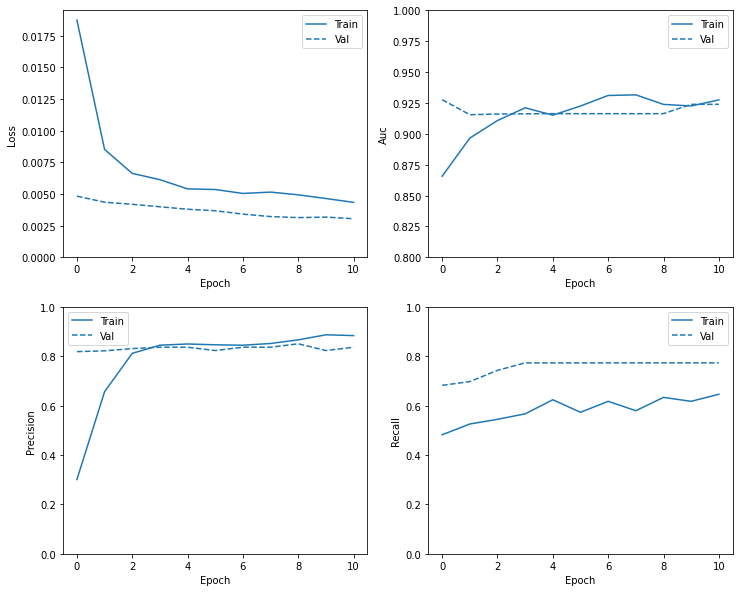

In [63]:
plot_metrics(base_line_history)

Note that the validation curve generally performs better than the training curve. This is mainly caused by the fact that the dropout layer is not active when evaluating the model.

Now let's evaluate our metrics:
We can use a [**confusion matrix**](https://developers.google.com/machine-learning/glossary/#confusion_matrix) to summarize the actual vs. predicted labels where the X axis is the predicted label and the Y axis is the actual label.

In [64]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [68]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transaction Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transaction Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transaction Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transaction Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

Evaluate your model on the test dataset and display the results for the metrics you created above.

loss :  0.005803351290524006
tp :  68.0
fp :  10.0
tn :  56842.0
fn :  42.0
accuracy :  0.9990870952606201
precision :  0.8717948794364929
recall :  0.6181818246841431
auc :  0.9317868947982788

Legitimate Transaction Detected (True Negatives):  56842
Legitimate Transaction Incorrectly Detected (False Positives):  10
Fraudulent Transaction Missed (False Negatives):  42
Fraudulent Transaction Detected (True Positives):  68
Total Fraudulent Transactions:  110


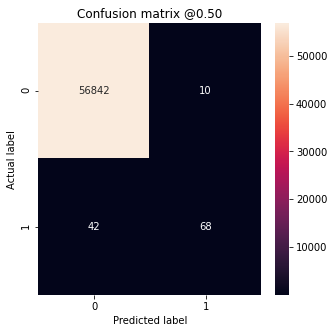

In [69]:
baseline_results = model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()
plot_cm(test_labels, test_predictions_baseline)

**If the model had predicted everything perfectly, this would be a diagonal matrix** where values off the main diagonal, indicating incorrect predictions, would be zero. In this case the matrix shows that you have relatively few false positives, meaning that there were relatively few legitimate transactions that were incorrectly flagged. However, you would likely want to have even fewer false negatives despite the cost of increasing the number of false positives. This trade off may be preferable because false negatives would allow fraudulent transactions to go through, whereas false positives may cause an email to be sent to a customer to ask them to verify their card activity.

Now plot the [ROC](https://developers.google.com/machine-learning/glossary#ROC). This plot is useful because it shows, at a glance, the range of performance the model can reach just by tuning the output threshold.

In [70]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False Positives [%]')
    plt.ylabel('True Positives [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

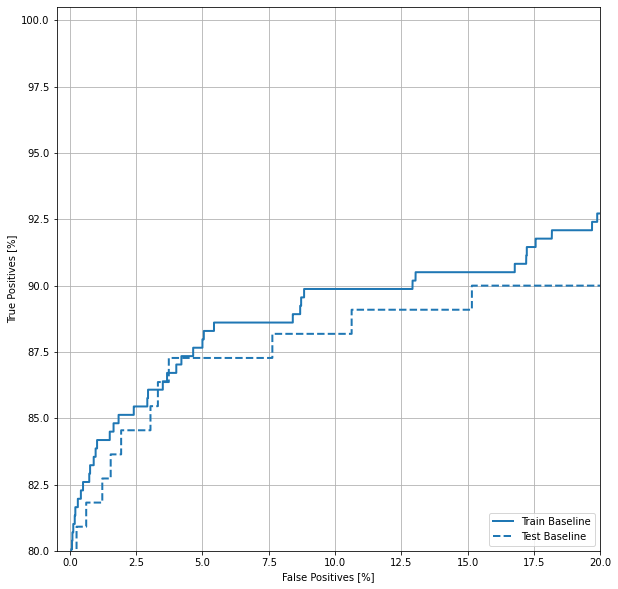

In [71]:
plot_roc('Train Baseline', train_labels, train_predictions_baseline, color=colors[0])
plot_roc('Test Baseline', test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

It looks like the precision is relatively high, but the recall and the area under the ROC curve (AUC) aren't as high as you might like. Classifiers often face challenges when trying to maximize both precision and recall, which is especially true when working with imbalanced datasets. It is important to consider the costs of different types of errors in the context of the problem you care about. In this example, a false negative (a fraudulent transaction is missed) may have a financial cost, while a false positive (a transaction is incorrectly flagged as fraudulent) may decrease user happiness.

Now let's calculate **class weights**:
The goal is to identify fraudulent transactions, but you don't have very many of those positive samples to work with, *so you would want to have the classifier heavily weight the few examples that are available.* You can do this by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class.

In [79]:
weight_for_0 = (1 / neg)*(total)/2.0
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0 : weight_for_0, 1 : weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


Now Let's try re-training and evaluating the model with class weights to see how that affects the predictions.
In the following step we will keep the preceeding initialization and add our initial class weights.

Note that using class_weights changes the range of the loss. This may affect the stability of the training depending on the optimizer. Optimizers whose step size is dependent on the magnitude of the gradient, like optimizers.SGD, may fail. The optimizer used here, optimizers.Adam, is unaffected by the scaling change. Also note that because of the weighting, the total losses are not comparable between the two models.

In [80]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(train_features,
                  train_labels,
                  batch_size=BATCH_SIZE,
                  epochs=EPOCHS,
                  callbacks=[early_stopping],
                  validation_data=(val_features, val_labels),
                  class_weight=class_weight)

Epoch 1/100
90/90 [==============================] - 3s 18ms/step - loss: 0.9968 - tp: 160.3516 - fp: 769.7582 - tn: 150052.5934 - fn: 119.8681 - accuracy: 0.9947 - precision: 0.2191 - recall: 0.5720 - auc: 0.9101 - val_loss: 0.0275 - val_tp: 55.0000 - val_fp: 224.0000 - val_tn: 45279.0000 - val_fn: 11.0000 - val_accuracy: 0.9948 - val_precision: 0.1971 - val_recall: 0.8333 - val_auc: 0.9652
Epoch 2/100
90/90 [==============================] - 1s 8ms/step - loss: 0.4878 - tp: 127.8901 - fp: 1111.5165 - tn: 92863.1209 - fn: 38.0440 - accuracy: 0.9882 - precision: 0.1084 - recall: 0.7882 - auc: 0.9277 - val_loss: 0.0343 - val_tp: 55.0000 - val_fp: 284.0000 - val_tn: 45219.0000 - val_fn: 11.0000 - val_accuracy: 0.9935 - val_precision: 0.1622 - val_recall: 0.8333 - val_auc: 0.9674
Epoch 3/100
90/90 [==============================] - 1s 8ms/step - loss: 0.3790 - tp: 133.8681 - fp: 1557.7802 - tn: 92414.7692 - fn: 34.1538 - accuracy: 0.9831 - precision: 0.0807 - recall: 0.7983 - auc: 0.9568 

Epoch 22/100
90/90 [==============================] - 1s 8ms/step - loss: 0.1281 - tp: 155.0330 - fp: 3175.1099 - tn: 90799.9670 - fn: 10.4615 - accuracy: 0.9663 - precision: 0.0479 - recall: 0.9428 - auc: 0.9904 - val_loss: 0.0779 - val_tp: 58.0000 - val_fp: 778.0000 - val_tn: 44725.0000 - val_fn: 8.0000 - val_accuracy: 0.9828 - val_precision: 0.0694 - val_recall: 0.8788 - val_auc: 0.9789
Epoch 23/100
90/90 [==============================] - 1s 9ms/step - loss: 0.1734 - tp: 149.9560 - fp: 3216.3516 - tn: 90758.8571 - fn: 15.4066 - accuracy: 0.9656 - precision: 0.0469 - recall: 0.9199 - auc: 0.9794 - val_loss: 0.0783 - val_tp: 58.0000 - val_fp: 786.0000 - val_tn: 44717.0000 - val_fn: 8.0000 - val_accuracy: 0.9826 - val_precision: 0.0687 - val_recall: 0.8788 - val_auc: 0.9790
Epoch 24/100
90/90 [==============================] - 1s 9ms/step - loss: 0.1824 - tp: 137.0659 - fp: 3187.2198 - tn: 90802.1538 - fn: 14.1319 - accuracy: 0.9659 - precision: 0.0409 - recall: 0.9120 - auc: 0.9768 -

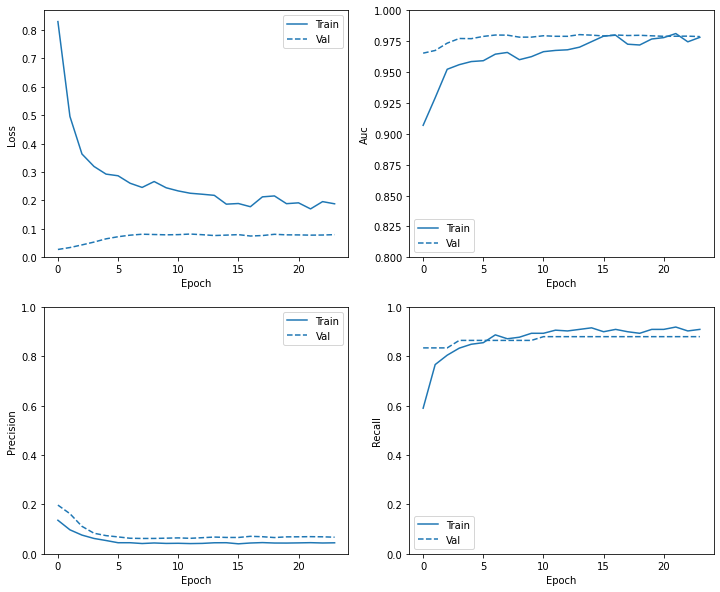

In [81]:
plot_metrics(weighted_history)

In [86]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.07406929135322571
tp :  97.0
fp :  972.0
tn :  55880.0
fn :  13.0
accuracy :  0.9827077984809875
precision :  0.09073901176452637
recall :  0.8818181753158569
auc :  0.9746444225311279

Legitimate Transaction Detected (True Negatives):  55880
Legitimate Transaction Incorrectly Detected (False Positives):  972
Fraudulent Transaction Missed (False Negatives):  13
Fraudulent Transaction Detected (True Positives):  97
Total Fraudulent Transactions:  110


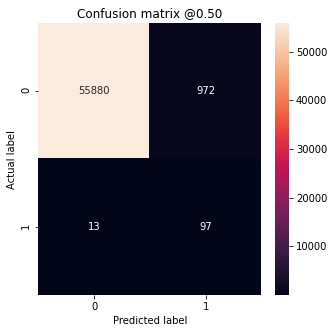

In [87]:
weighted_results = weighted_model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name,  ': ',  value)
print()
plot_cm(test_labels, test_predictions_weighted)

Here you can see that with class weights the accuracy and precision are lower because there are more false positives, but conversely the recall and AUC are higher because the model also found more true positives. Despite having lower accuracy, this model has higher recall (and identifies more fraudulent transactions). Of course, there is a cost to both types of error (you wouldn't want to bug users by flagging too many legitimate transactions as fraudulent, either). Carefully consider the trade-offs between these different types of errors for your application.

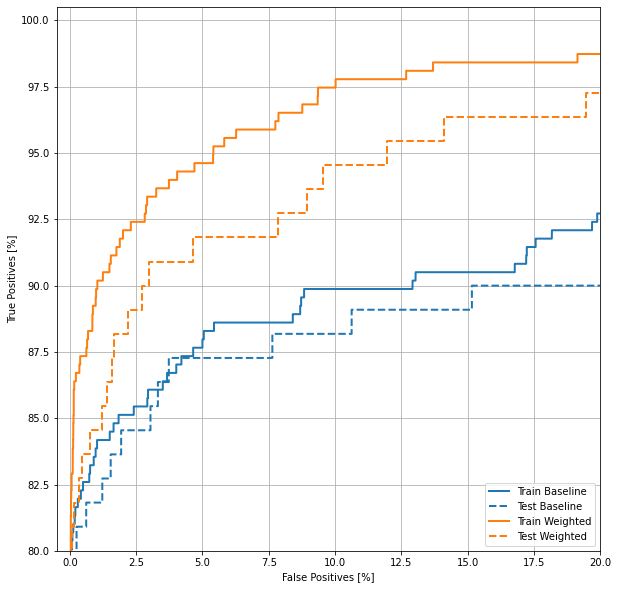

In [88]:
plot_roc('Train Baseline', train_labels, train_predictions_baseline, color=colors[0])
plot_roc('Test Baseline', test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc('Train Weighted', train_labels, train_predictions_weighted, color=colors[1])
plot_roc('Test Weighted', test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plt.legend(loc='lower right')

Now Let's **Oversample the minority class**

In [89]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

**Using NumPy**

In [111]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features)) #Generates a random sample from a given 1-D array

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

#res_pos_features.shape (181960, 29)

resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)

resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(363920, 29)

**Using tf.data**

In [113]:
BUFFER_SIZE = 1000000

def make_ds(features, labels):
    ds = tf.data.Dataset.from_tensor_slices((features, labels))
    ds = ds.shuffle(BUFFER_SIZE).repeat()
    return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

for features, label in pos_ds.take(1):
    print('Features:\n', features.numpy())
    print()
    print('Label: ', label.numpy())

Features:
 [ 0.47085669  0.20853275 -1.9046338   1.21446218 -2.17585584 -0.47879783
 -3.04860334  1.09930964  0.78054577 -2.66116239  2.96378689 -2.55624096
 -1.56336926 -3.10483518  1.17991774 -5.         -5.         -1.80222887
  3.68914232  0.21712244  1.21918704  2.03811689  1.14029879  0.290431
 -3.46917741 -1.11097797  1.20191173 -0.14839107  0.23200898]

Label:  1


In [116]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

for features, label in resampled_ds.take(1):
    print(label.numpy().mean())

0.50927734375


To use this dataset, you'll need the number of steps per epoch.

The definition of "epoch" in this case is less clear. Say it's the number of batches required to see each negative example once:

In [117]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

278.0

Now Let's try training the model with **the resampled data** set instead of using **class weights** to see how these methods compare.

In [121]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

output_layer = resampled_model.layers[-1]
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2)

resampled_history = resampled_model.fit(resampled_ds,
                                       epochs=EPOCHS,
                                       steps_per_epoch=resampled_steps_per_epoch,
                                       callbacks=[early_stopping],
                                       validation_data = val_ds)

Epoch 1/100
278/278 [==============================] - 13s 35ms/step - loss: 0.5286 - tp: 133284.1971 - fp: 59931.9283 - tn: 140258.9068 - fn: 10199.6272 - accuracy: 0.7949 - precision: 0.6564 - recall: 0.9241 - auc: 0.9446 - val_loss: 0.2350 - val_tp: 58.0000 - val_fp: 1318.0000 - val_tn: 44185.0000 - val_fn: 8.0000 - val_accuracy: 0.9709 - val_precision: 0.0422 - val_recall: 0.8788 - val_auc: 0.9732
Epoch 2/100
278/278 [==============================] - 11s 39ms/step - loss: 0.2116 - tp: 133962.7634 - fp: 10907.0215 - tn: 132361.9928 - fn: 9480.8817 - accuracy: 0.9259 - precision: 0.9201 - recall: 0.9332 - auc: 0.9737 - val_loss: 0.1262 - val_tp: 58.0000 - val_fp: 906.0000 - val_tn: 44597.0000 - val_fn: 8.0000 - val_accuracy: 0.9799 - val_precision: 0.0602 - val_recall: 0.8788 - val_auc: 0.9778
Epoch 3/100
278/278 [==============================] - 12s 42ms/step - loss: 0.1574 - tp: 135066.9355 - fp: 6182.2724 - tn: 137278.5520 - fn: 8184.8996 - accuracy: 0.9489 - precision: 0.9553 -

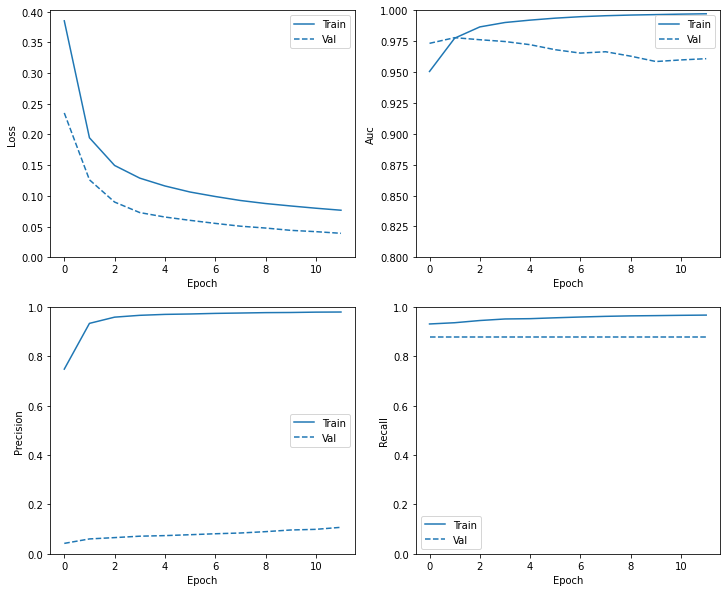

In [122]:
plot_metrics(resampled_history)

**Re-train**

Because training is easier on the balanced data, the above training procedure may overfit quickly.

So break up the epochs to give the **callbacks.EarlyStopping** finer control over when to stop training.

In [125]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1]
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(resampled_ds,
                                        #These are not real epochs
                                       steps_per_epoch=20,
                                       epochs=10*EPOCHS,
                                       callbacks = [early_stopping],
                                       validation_data = (val_ds))

Epoch 1/1000
20/20 [==============================] - 5s 88ms/step - loss: 0.7856 - tp: 10123.0000 - fp: 7996.6190 - tn: 48614.1905 - fn: 1265.6667 - accuracy: 0.8724 - precision: 0.5474 - recall: 0.8839 - auc: 0.9607 - val_loss: 1.0411 - val_tp: 66.0000 - val_fp: 32788.0000 - val_tn: 12715.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.2805 - val_precision: 0.0020 - val_recall: 1.0000 - val_auc: 0.9577
Epoch 2/1000
20/20 [==============================] - 1s 40ms/step - loss: 0.6398 - tp: 10398.6190 - fp: 6853.4762 - tn: 4368.2381 - fn: 810.1429 - accuracy: 0.6539 - precision: 0.5988 - recall: 0.9259 - auc: 0.8934 - val_loss: 0.8749 - val_tp: 64.0000 - val_fp: 27207.0000 - val_tn: 18296.0000 - val_fn: 2.0000 - val_accuracy: 0.4029 - val_precision: 0.0023 - val_recall: 0.9697 - val_auc: 0.9614
Epoch 3/1000
20/20 [==============================] - 1s 45ms/step - loss: 0.5481 - tp: 10518.1429 - fp: 6050.2381 - tn: 5163.3810 - fn: 698.7143 - accuracy: 0.6951 - precision: 0.6323 - recall: 0.9

Epoch 22/1000
20/20 [==============================] - 1s 48ms/step - loss: 0.1943 - tp: 10496.4762 - fp: 750.6667 - tn: 10455.7619 - fn: 727.5714 - accuracy: 0.9338 - precision: 0.9334 - recall: 0.9345 - auc: 0.9774 - val_loss: 0.1584 - val_tp: 58.0000 - val_fp: 990.0000 - val_tn: 44513.0000 - val_fn: 8.0000 - val_accuracy: 0.9781 - val_precision: 0.0553 - val_recall: 0.8788 - val_auc: 0.9775
Epoch 23/1000
20/20 [==============================] - 1s 48ms/step - loss: 0.1824 - tp: 10503.9048 - fp: 642.5238 - tn: 10598.6190 - fn: 685.4286 - accuracy: 0.9408 - precision: 0.9432 - recall: 0.9384 - auc: 0.9800 - val_loss: 0.1519 - val_tp: 58.0000 - val_fp: 975.0000 - val_tn: 44528.0000 - val_fn: 8.0000 - val_accuracy: 0.9784 - val_precision: 0.0561 - val_recall: 0.8788 - val_auc: 0.9776
Epoch 24/1000
20/20 [==============================] - 1s 51ms/step - loss: 0.1796 - tp: 10585.9048 - fp: 638.1429 - tn: 10518.3333 - fn: 688.0952 - accuracy: 0.9410 - precision: 0.9429 - recall: 0.9396 - a

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping


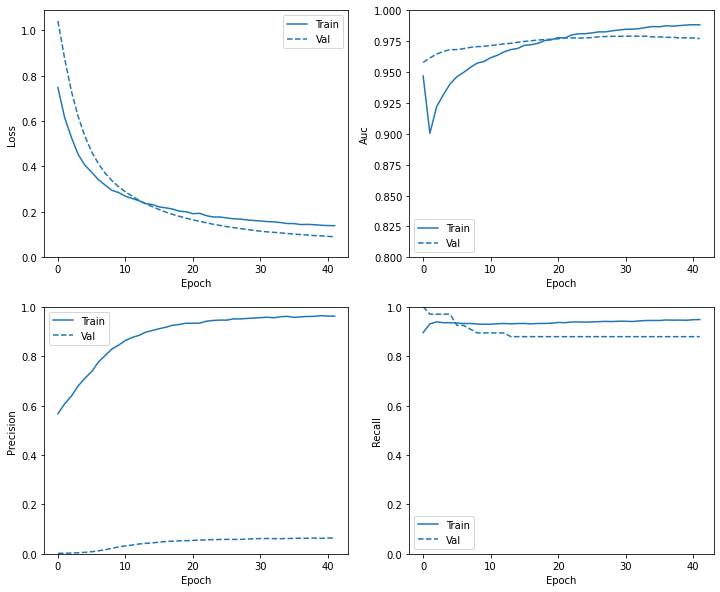

In [126]:
plot_metrics(resampled_history)

In [128]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.9746444225311279
tp :  0.9746444225311279
fp :  0.9746444225311279
tn :  0.9746444225311279
fn :  0.9746444225311279
accuracy :  0.9746444225311279
precision :  0.9746444225311279
recall :  0.9746444225311279
auc :  0.9746444225311279

Legitimate Transaction Detected (True Negatives):  55709
Legitimate Transaction Incorrectly Detected (False Positives):  1143
Fraudulent Transaction Missed (False Negatives):  12
Fraudulent Transaction Detected (True Positives):  98
Total Fraudulent Transactions:  110


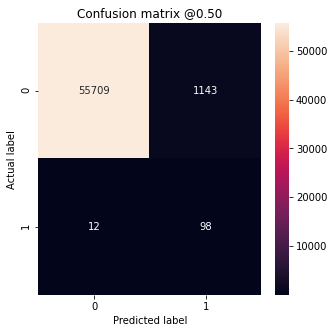

In [130]:
resampled_results = resampled_model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)
for name, values in zip(resampled_model.metrics_names, resampled_results):
    print(name, ': ', value)
print()
    
plot_cm(test_labels, test_predictions_resampled)

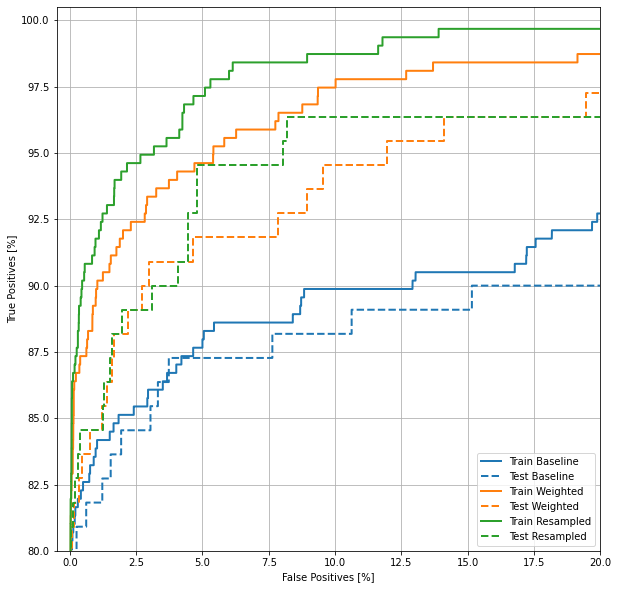

In [131]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right')

**Conclusion:**
Imbalanced data classification is an inherently difficult task since there are so few samples to learn from. You should always start with the data first and do your best to collect as many samples as possible and give substantial thought to what features may be relevant so the model can get the most out of your minority class. At some point your model may struggle to improve and yield the results you want, so it is important to keep in mind the context of your problem and the trade offs between different types of errors.